In [9]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import seaborn as sns

Данные

In [10]:
data = pd.read_csv('forestfires.csv')
data.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0


In [11]:
#перевожу заголовки в загланые буквы
data.columns = map(str.upper, data.columns)
# удаляю пропущенные значения, если они есть
data_clean = data.dropna()
# Перевод качественных признаком в количественные
data_clean.MONTH.replace(to_replace=dict(mar=3, oct=10, jan = 1, feb = 2, apr = 4, may = 5, jun = 6, jul = 7, aug = 8, sep = 9, nov = 11, dec = 12), inplace=True)
data_clean.DAY.replace(to_replace=dict(mon = 1, tue = 2, wed = 3, thu = 4, fri = 5, sat = 6, sun = 7), inplace=True)

In [12]:
data_clean.head()

,X,Y,MONTH,DAY,FFMC,DMC,DC,ISI,TEMP,RH,WIND,RAIN,AREA
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [13]:
#выбираю матрицу признаков и целевой признак 
predvar= data_clean[['X', "Y", 'MONTH', 'DAY','FFMC','DMC','DC','ISI','TEMP','RH','WIND','RAIN']]
target = data_clean.AREA

In [14]:
# стандартизация признаков (mean=0 and sd=1)
predictors=predvar.copy()
from sklearn import preprocessing
predictors['X']=preprocessing.scale(predictors['X'].astype('float64'))
predictors['Y']=preprocessing.scale(predictors['Y'].astype('float64'))
predictors['MONTH']=preprocessing.scale(predictors['MONTH'].astype('float64'))
predictors['DAY']=preprocessing.scale(predictors['DAY'].astype('float64'))
predictors['FFMC']=preprocessing.scale(predictors['FFMC'].astype('float64'))
predictors['DMC']=preprocessing.scale(predictors['DMC'].astype('float64'))
predictors['DC']=preprocessing.scale(predictors['DC'].astype('float64'))
predictors['ISI']=preprocessing.scale(predictors['ISI'].astype('float64'))
predictors['TEMP']=preprocessing.scale(predictors['TEMP'].astype('float64'))
predictors['RH']=preprocessing.scale(predictors['RH'].astype('float64'))
predictors['WIND']=preprocessing.scale(predictors['WIND'].astype('float64'))
predictors['RAIN']=preprocessing.scale(predictors['RAIN'].astype('float64'))

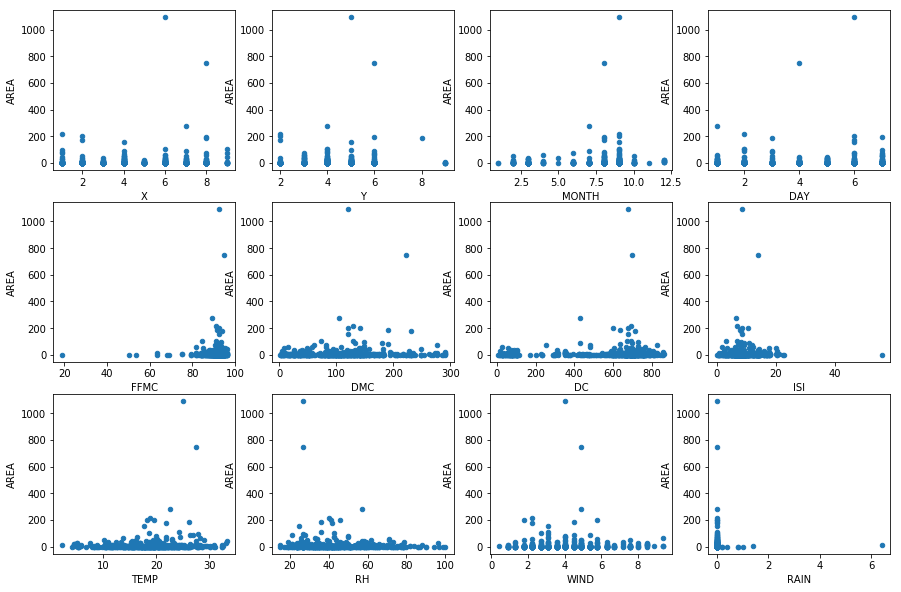

In [15]:
# график зависимости целового признака от остальных
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(data_clean.columns[:-1]):
    data_clean.plot(feature, y="AREA", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

(array([495.,  13.,   1.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   0.   ,   54.542,  109.084,  163.626,  218.168,  272.71 ,
         327.252,  381.794,  436.336,  490.878,  545.42 ,  599.962,
         654.504,  709.046,  763.588,  818.13 ,  872.672,  927.214,
         981.756, 1036.298, 1090.84 ]),
 <a list of 20 Patch objects>)

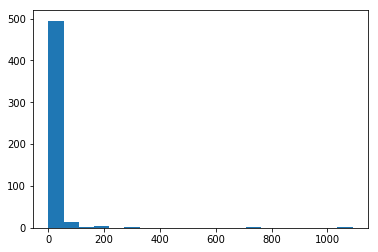

In [30]:
#распределение значений целевого признака
plt.hist(data_clean['AREA'], bins = 20)

Видно, что выборка несбалансированная

In [16]:
#зависимость площади от координат

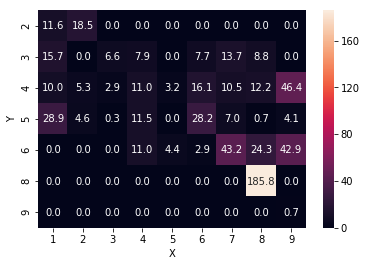

In [17]:
heat_point = data_clean.pivot_table(index = 'Y', columns = 'X', values = 'AREA', aggfunc = np.mean).fillna(0)
sns.heatmap(heat_point, annot=True, fmt=".1f")

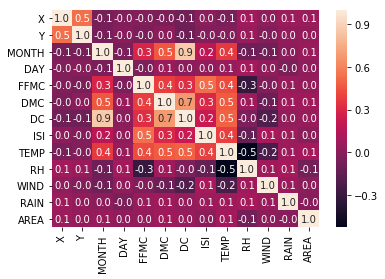

In [18]:
#попарные корреляции между признаками
correlations = data_clean.corr()
sns.heatmap(correlations, annot=True, fmt=".1f")

## Линейная регрессия с Лассо-регуляризацией

In [19]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,
                                                              test_size=.3, random_state=123)

In [20]:
model=LassoLarsCV(cv=10, precompute=False).fit(pred_train,tar_train)
predictions = model.predict(pred_test)

In [21]:
# коэффициены регрессии
print(dict(zip(predictors.columns, model.coef_)))

{'X': 5.132735563872145, 'Y': 0.5649132148022705, 'MONTH': 0.0, 'DAY': 0.0, 'FFMC': 0.0, 'DMC': 0.0, 'DC': 0.0, 'ISI': 0.0, 'TEMP': 6.3461296386794706, 'RH': -0.9118685549026231, 'WIND': 0.0, 'RAIN': 0.0}


По весовым коэффициентам видно, что имеют значение только признаки X, Y, TEMP, RH. Коэффициенты у всех остальных признаков = 0. Самые значительные признаки: X, TEMP.

In [22]:
model.alphas_

array([0.49848813, 0.42093896, 0.22389023, 0.21011832, 0.16261169])

Text(0.5,1,'Regression Coefficients Progression for Lasso Paths')

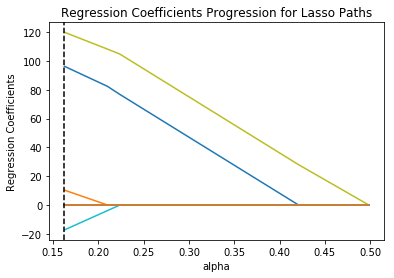

In [23]:
# график зависимости значений весов от параметра регуляризации
alphas = model.alphas_
ax = plt.gca()
plt.plot(alphas, model.coef_path_.T)
plt.axvline(model.alpha_, linestyle='--', color='k',
            label='alpha CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('alpha')
plt.title('Regression Coefficients Progression for Lasso Paths')

In [24]:
model.cv_alphas_

array([0.00000000e+00, 2.89925747e-04, 1.25216638e-03, 4.44105882e-03,
       7.18747275e-03, 1.11239542e-02, 1.12287358e-02, 1.13010172e-02,
       1.38963901e-02, 2.03711651e-02, 2.16759709e-02, 2.20560935e-02,
       2.34121677e-02, 2.39822724e-02, 2.48220196e-02, 2.51953867e-02,
       2.69034288e-02, 2.83789676e-02, 2.92831490e-02, 2.94523925e-02,
       2.98113149e-02, 3.05515498e-02, 3.27048699e-02, 3.41660940e-02,
       3.54064817e-02, 3.77366088e-02, 4.11757076e-02, 5.29828154e-02,
       5.51174548e-02, 5.71177186e-02, 6.91531615e-02, 7.18899421e-02,
       7.21811474e-02, 7.36198294e-02, 7.40317484e-02, 7.81986413e-02,
       8.67574457e-02, 8.76998751e-02, 8.94200798e-02, 9.27034578e-02,
       9.41751479e-02, 9.42818604e-02, 9.49940232e-02, 9.70888415e-02,
       9.84945306e-02, 9.84974526e-02, 9.86257797e-02, 9.88870735e-02,
       9.89423385e-02, 9.99089767e-02, 1.01661174e-01, 1.02246267e-01,
       1.02537098e-01, 1.02759505e-01, 1.05626278e-01, 1.07050521e-01,
      

c:\users\anna\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
c:\users\anna\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function cv_mse_path_ is deprecated; Attribute ``cv_mse_path_`` is deprecated in 0.18 and will be removed in 0.20. Use ``mse_path_`` instead
  warnings.warn(msg, category=DeprecationWarning)
c:\users\anna\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function cv_mse_path_ is deprecated; Attribute ``cv_mse_path_`` is deprecated in 0.18 and will be removed in 0.20. Use ``mse_path_`` instead
  warnings.warn(msg, category=DeprecationWarning)


Text(0.5,1,'Mean squared error on each fold')

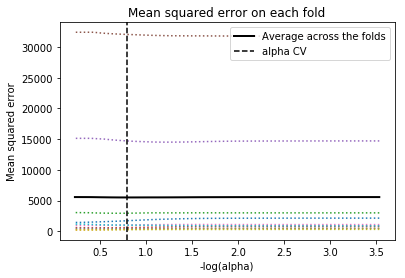

In [25]:
# plot mean square error for each fold
m_log_alphascv = -np.log10(model.cv_alphas_)
plt.figure()
plt.plot(m_log_alphascv, model.cv_mse_path_, ':')
plt.plot(m_log_alphascv, model.cv_mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')

Выбранное значение параметра регуляризации: 96
Обученные веса, соответствующие этому значению: [('X', 0.0), ('Y', 0.0), ('MONTH', 0.0), ('DAY', 0.0), ('FFMC', 0.0), ('DMC', 0.0), ('DC', 0.0), ('ISI', 0.0), ('TEMP', 0.0), ('RH', -0.0), ('WIND', 0.0), ('RAIN', -0.0)]
Усреднённые по строкам MSE: [4160.62982825 4160.62982825 4160.62982825 4160.62982825 4160.62982825
 4160.62982825 4160.62982825 4160.62982825 4160.62982825 4160.62982825
 4160.62982825 4160.62982825 4160.62982825 4160.62982825 4160.62982825
 4160.62982825 4160.62982825 4160.62982825 4164.7086439  4164.08766306]


Text(0,0.5,'MSE')

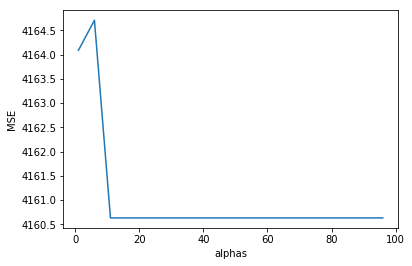

In [26]:
#Регрессор LassoCV обучен на всех параметрах регуляризации. График усреднённой MSE в зависимости от параметра регуляризации.
from sklearn.linear_model import LassoCV
headers = data_clean.columns.values.tolist()

alphas = np.arange(1, 100, 5)
lasso_cv = LassoCV(alphas = alphas)
lasso_cv.fit(predictors, target)
print('Выбранное значение параметра регуляризации:', lasso_cv.alpha_)
print('Обученные веса, соответствующие этому значению:', list(zip(headers, lasso_cv.coef_)))
mses = np.mean(lasso_cv.mse_path_[:, :], axis=1)
print('Усреднённые по строкам MSE:',mses)

plt.plot(lasso_cv.alphas_, mses)
plt.xlabel('alphas')
plt.ylabel('MSE')

In [27]:
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE')
print(train_error)
print ('test data MSE')
print(test_error)

training data MSE
5388.390897028627
test data MSE
754.0619812798259


## Зависимость значения ошибки от сложности (числа признаков) на обучении и контроле.

In [28]:
mses1 = []
mses2 = []
for i in range(1,13):
    model1=LassoLarsCV(cv=10, precompute=False).fit(pred_train.iloc[:,0:i],tar_train)
    predictions1 = model1.predict(pred_test.iloc[:,0:i])
    #print(dict(zip(predictors.columns, model.coef_)))
    scores1 = -1*cross_val_score(model1, predictors.iloc[:,0:i], target, scoring='neg_mean_squared_error', cv=10)
    #print('MSE: (i признаков)', metrics.mean_squared_error(tar_test, predictions1))
    #print('MSE: (cv = 10)', scores1.mean())
    mses1 = np.append(mses1, [metrics.mean_squared_error(tar_test, predictions1)])
    mses2 = np.append(mses2, [scores1.mean()])

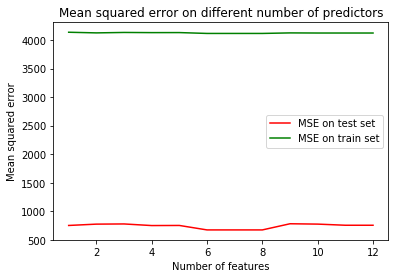

In [31]:
Npredictors = range(1,13)
# график MSE для разного количество признаков на test set
plt.figure()
plt.plot(Npredictors, mses1, color = 'red',label='MSE on test set')
plt.plot(Npredictors, mses2, color = 'green', label='MSE on train set')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on different number of predictors')
plt.savefig('Gr1.png', bbox_inches='tight', dpi=500)